<a href="https://colab.research.google.com/github/sw4050git/Report/blob/main/ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#検索技術 学期末課題レポート
学籍番号：20X3160　氏名：渡邊慎吾　提出日時：2022/7/25


##1.データの準備
 スマートフォン向けデジタルカードゲーム「Shadowverse」のカード画像180枚を公式のデッキ作成支援ツールサイト「ShadowversePortal」よりダウンロードし、分析対象のデータとした。

 カードは「フォロワー」、「スペル」、「アミュレット」と呼ばれる3つのタイプに分類され、分析対象のデータとしてそれぞれのタイプのカード画像をを60枚ずつ用意した。解像度は全て199x259pxである。
 
例として、各タイプのカード画像を1枚ずつ以下に示す。
 
 

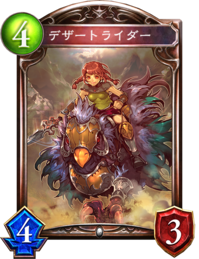
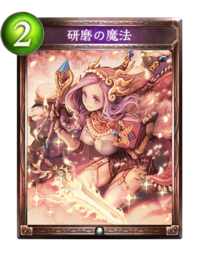
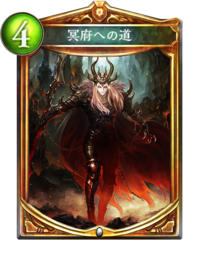


図1 Shadowverseのカード画像例



図1の左の画像がフォロワー、中央の画像がスペル、右の画像がアミュレットである。 カードのタイプは画像の枠から見た目で判別することができる。フォロワーはカードの枠上部がアーチ状になっており、枠左下、枠右下にステータスが表示されている。スペルはカード枠が全体として長方形であり、アミュレットはカード枠上部が三角形となっている。

画像にはフォロワーなら「f」、スペルなら「s」、アミュレットなら「a」というようにラベルを付けた。また、各タイプのカード画像50枚ずつ計150枚を訓練用データ、各タイプのカード画像10枚ずつ計30枚をテスト用データに事前に分けた。

##2.分析手法

1で説明した訓練用データを使用し、SVMにによって学習を行いモデルを作成した。また、作成したモデルを用いてテスト用データを各タイプに分類した。

SVMは教師ありの機械学習アルゴリズムであり、各データをラベルごとに最も適切に分離できる境界線を見つけ出すというものである。各ラベルにおいて境界線に最も近いデータ点を考え、それらのデータ点と境界線の距離が可能な限り大きくなるように境界線を決定することによって適切な境界線を見つけ出している。

階層化クラスタリングでは、分類の数を任意に決める事ができないため、3つのタイプに分類するという今回の目的には合わず、K-Means法では、分類したいデータにタイプの偏りが生じた場合に精度が落ちることが予想される。一方、SVMは事前に偏りがないデータを用いて学習したモデルを作成でき、テストデータの各タイプの数に影響を受けず分類が可能なことから、今回の分析手法として用いた。

SVMによる学習を行う前に、画像データを縦横それぞれ4分の1にリサイズし、平坦化を行ったのち主成分分析によってデータの次元数を2まで圧縮した。

主成分分析はデータの各次元ごとに分散をとり、分散が大きい次元を重要と見なしてピックアップすることによってデータの次元を圧縮する手法である。今回はSVMによって作られたモデルと、テストデータの分類の様子を可視化するために画像データを2次元に圧縮した。

以下のコードがSVMによるモデル作成とテストデータの分類を行ったプログラムのコードと実行結果である。SVMのカーネルはRBF、パラメータはデフォルトの値を用いた。

In [173]:
cd /content/drive/MyDrive/検索技術/ex/

/content/drive/MyDrive/検索技術/ex


In [174]:
#インポート
import os
from PIL import Image
import numpy as np
from sklearn import svm, metrics
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
 
np.random.seed(5)

In [175]:
#訓練用データのロード
train_img_paths = []
train_labels=[]
for root,subdir,files in os.walk("./train_img/") :
    for s in subdir : 
      for r, d ,f in os.walk(root+s):
        for file in f:
          train_labels.append(os.path.join(r, file).split('/')[-2])
          train_img_paths.append(os.path.join(r, file))

In [176]:
#テスト用データのロード
test_img_paths = []
test_labels=[]
for root,subdir,files in os.walk("./test_img/") :
    for s in subdir : 
      for r, d ,f in os.walk(root+s):
        for file in f:
          test_labels.append(os.path.join(r, file).split('/')[-2])
          test_img_paths.append(os.path.join(r, file))
test_img_num = len(test_img_paths)

In [177]:
#データの前処理

#画像データをarrayに変換
def img_to_matrix(img):
    img_array = np.asarray(img)
    return img_array
#データの平坦化
def flatten_img(img_array):
    s = img_array.shape[0] * img_array.shape[1] * img_array.shape[2]
    img_width = img_array.reshape(1, s)
    return img_width[0]

#データの前処理
train_dataset = []
for i in train_img_paths:
    img = Image.open(i)
    img = img.resize((int(199/4), int(259/4)), Image.BICUBIC)
    img = img_to_matrix(img)
    img = flatten_img(img)
    train_dataset.append(img)
train_dataset = np.array(train_dataset)
print(train_dataset.shape)

test_dataset = []
for i in test_img_paths:
    img = Image.open(i)
    img = img.resize((int(199/4), int(259/4)), Image.BICUBIC)
    img = img_to_matrix(img)
    img = flatten_img(img)
    test_dataset.append(img)
test_dataset = np.array(test_dataset)
print(test_dataset.shape)

(150, 12544)
(30, 12544)


In [178]:
# 次元数圧縮
n = train_dataset.shape[0]
batch_size = 3
ipca = IncrementalPCA(n_components=batch_size-1)
for i in range(n//batch_size):
    train_r_dataset = ipca.partial_fit(train_dataset[i*batch_size:(i+1)*batch_size])

train_r_dataset = ipca.transform(train_dataset)
print(train_r_dataset.shape)

n = test_dataset.shape[0]
for i in range(n//batch_size):
    test_r_dataset = ipca.partial_fit(test_dataset[i*batch_size:(i+1)*batch_size])
test_r_dataset = ipca.transform(test_dataset)
print(test_r_dataset.shape)

(150, 2)
(30, 2)


In [203]:
#SVCによる学習
clf = svm.SVC(kernel='rbf')
clf.fit(train_r_dataset,train_labels)

#テストデータの分類
pred = clf.predict(test_r_dataset)



##3.分析結果の表示、考察

SVMによる学習で作成したモデルでのテストデータの分類結果を以下に示す。

In [204]:
ac_score = metrics.accuracy_score(test_labels, pred)
cl_score = metrics.classification_report(test_labels, pred)
print('正解率：',ac_score)
print('詳細:')
print(cl_score)

正解率： 1.0
詳細:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00        10
           f       1.00      1.00      1.00        10
           s       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



上の表はSVMで作成したモデルを用いてテストデータを分類した結果である。acuuracyが1となっており、全てのテストデータを正しく分類することができた。

また、SVMによって作成したモデル及び訓練用データをプロットした図を以下に示す。

(-5166.670233854524, 6256.162124072698)

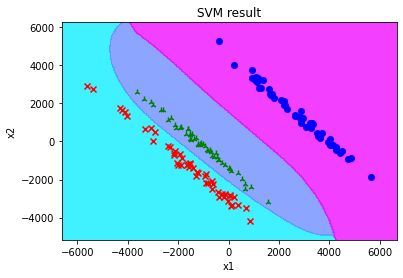

In [205]:
x_min, x_max = train_r_dataset[:,0].min() - 1000, train_r_dataset[:,0].max() + 1000 # max & min with margin 1000
y_min, y_max = train_r_dataset[:,1].min() - 1000, train_r_dataset[:,1].max() + 1000 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
for z in range(len(Z)):
  for i in range(len(Z[z])):
    if(Z[z][i]=='s'):
      Z[z][i]=1
    elif (Z[z][i]=='a'):
      Z[z][i]=2
    else:
      Z[z][i]=3
plt.contourf(xx, yy, Z, cmap = cm.cool, alpha= 0.8)

for i in range(len(train_labels)):
  if(train_labels[i]=='s'):
    plt.scatter(train_r_dataset[i,0], train_r_dataset[i, 1], marker='x',c="red")
  if(train_labels[i]=='a'):
    plt.scatter(train_r_dataset[i,0], train_r_dataset[i, 1], marker='2',c="green")
  if(train_labels[i]=='f'):
    plt.scatter(train_r_dataset[i,0], train_r_dataset[i, 1], marker='o',c="blue")

# Title and X-axis, Y-axis
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SVM result')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


図2 作成したモデルと訓練用データ

図2のピンク色の領域がフォロワー、薄い青色の領域がアミュレット、水色の領域がスペルと分類される。青色の丸がフォロワー、緑色の三角形がアミュレット、赤色のxがスペルの訓練用データをプロットしたものである。全て正しい領域にプロットされるように境界が作られていることを確認できた。

また、アミュレットとスペルのデータの距離が近く、フォロワーのデータは距離が離れていることから、アミュレットとスペルの画像は比較的似ており、フォロワーの画像は他2つのタイプの画像に似ていないということがわかる。実際に、図1のカード画像を見るとフォロワーの枠のみステータスが表示されているなど他2つのタイプに比べて差異が大きいことが確認できる。

また、モデルを用いてテストデータを分類した図を以下に示す。

(-4937.809092992453, 4783.981421172566)

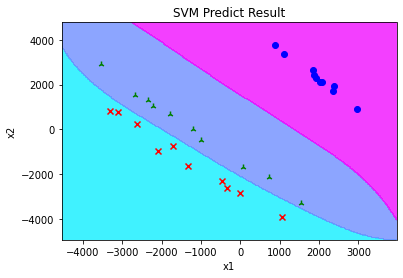

In [206]:
x_min, x_max = test_r_dataset[:,0].min() - 1000, test_r_dataset[:,0].max() + 1000 # max & min with margin 1000
y_min, y_max = test_r_dataset[:,1].min() - 1000, test_r_dataset[:,1].max() + 1000 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
for z in range(len(Z)):
  for i in range(len(Z[z])):
    if(Z[z][i]=='s'):
      Z[z][i]=1
    elif (Z[z][i]=='a'):
      Z[z][i]=2
    else:
      Z[z][i]=3
plt.contourf(xx, yy, Z, cmap = cm.cool, alpha= 0.8)

for i in range(len(test_labels)):
  if(test_labels[i]=='s'):
    plt.scatter(test_r_dataset[i,0], test_r_dataset[i, 1], marker='x',c="red")
  if(test_labels[i]=='a'):
    plt.scatter(test_r_dataset[i,0], test_r_dataset[i, 1], marker='2',c="green")
  if(test_labels[i]=='f'):
    plt.scatter(test_r_dataset[i,0], test_r_dataset[i, 1], marker='o',c="blue")

# Title and X-axis, Y-axis
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SVM Predict Result')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

図3 作成したモデルとテストデータ

図3は図2の訓練用データの代わりにテストデータをプロットしたものである。全てのデータが正しい領域に入っており、正確に分類できていることが確認できた。

図2と同様にスペルとアミュレットのデータが近く、フォロワーのデータが離れている。この結果を見ると、フォロワーの分類間違いは起きにくそうだが、スペルとアミュレットの分類間違いは比較的起こりやすそうだと考えられる。

#4.まとめ

Shadowverseのカード画像データを用意し、主成分分析をかけて2次元に圧縮してSVMを用いることでカードのタイプを分類するモデルを作成した。自身にとって身近なものをデータとして扱うことで興味を強く保つことができ、今回用いた分析手法について深く理解することができた。

#5.参考文献、データダウンロード元

参考文献  
検索技術 各講義資料

データダウンロード元  
ShadowversePortal  
https://shadowverse-portal.com/?lang=ja
